# Environment

In [33]:
import os
import tarfile
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import scipy
import gc
import sys
# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

import Helper as fn

In [34]:
# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET/GSE212252"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SET/GSE212252


In [35]:
# Define the paths for all datasets
data_paths = [
    './DATA/EMBRYO_CRE_NEGATIVE',
    './DATA/EMBRYO_CRE_POSITIVE',
    './DATA/POST_NATAL_CRE_NEGATIVE',
    './DATA/POST_NATAL_CRE_POSITIVE'
]

# Load all datasets

In [36]:
# Load all datasets
adatas = []
for path in data_paths:
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=True
    )
    # Extract origin and condition from the directory name
    dir_name = os.path.basename(path)
    origin, condition = dir_name.split('_', 1)
    
    # Add columns to identify the origin and condition of each cell
    adata.obs['origin'] = origin
    adata.obs['condition'] = condition
    
    adatas.append(adata)

# Combine all datasets
adata_combined = ad.concat(adatas, join='outer', merge='same')

# Clean up to free memory
del adatas
gc.collect()

# The combined dataset is now in adata_combined
adata = adata_combined

... reading from cache file cache/DATA-EMBRYO_CRE_NEGATIVE-matrix.h5ad


... reading from cache file cache/DATA-EMBRYO_CRE_POSITIVE-matrix.h5ad
... reading from cache file cache/DATA-POST_NATAL_CRE_NEGATIVE-matrix.h5ad
... reading from cache file cache/DATA-POST_NATAL_CRE_POSITIVE-matrix.h5ad


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [37]:
adata

AnnData object with n_obs × n_vars = 2933639 × 32286
    obs: 'origin', 'condition'
    var: 'gene_ids', 'feature_types'

In [38]:
adata.obs.head()

,origin,condition
AAACAGCCAAACAACA-1,EMBRYO,CRE_NEGATIVE
AAACAGCCAAACATAG-1,EMBRYO,CRE_NEGATIVE
AAACAGCCAAACCCTA-1,EMBRYO,CRE_NEGATIVE
AAACAGCCAAACCTAT-1,EMBRYO,CRE_NEGATIVE
AAACAGCCAAACCTTG-1,EMBRYO,CRE_NEGATIVE


In [39]:
adata.obs.origin.value_counts()

origin
POST      1472264
EMBRYO    1461375
Name: count, dtype: int64

In [40]:
adata.X

<2933639x32286 sparse matrix of type '<class 'numpy.float32'>'
	with 169823478 stored elements in Compressed Sparse Row format>

In [41]:
non_zero_elements = adata.X.data[:10] if scipy.sparse.issparse(adata.X) else adata.X[np.nonzero(adata.X)][:10]

print("First 10 non-zero elements of adata.X:")
print(non_zero_elements)

First 10 non-zero elements of adata.X:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [42]:
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

In [43]:
# Calculate QC metrics
mito_genes = adata.var_names.str.startswith(('mt-', 'Mt-', 'MT-'))   
ribo_genes = adata.var_names.str.contains('^Rps|^Rpl')

adata.var['mito'] = mito_genes
adata.var['ribo'] = ribo_genes

sc.pp.calculate_qc_metrics(adata, log1p=True, qc_vars=['mito','ribo'], 
                           inplace=True, percent_top=None)

adata.obs['gene_UMI_ratio'] = adata.obs['n_genes_by_counts'] / adata.obs['total_counts']
adata.obs['log1p_gene_UMI_ratio'] = np.log1p(adata.obs['gene_UMI_ratio'])

In [44]:
adata.var.head()

,gene_ids,feature_types,mito,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Xkr4,ENSMUSG00000051951,Gene Expression,False,False,21128,0.029003,0.028591,99.279802,85085.0,11.351418
Gm1992,ENSMUSG00000089699,Gene Expression,False,False,1300,0.000507,0.000506,99.955686,1486.0,7.304516
Gm19938,ENSMUSG00000102331,Gene Expression,False,False,4073,0.001765,0.001764,99.861162,5179.0,8.552561
Gm37381,ENSMUSG00000102343,Gene Expression,False,False,50,0.000029,0.000029,99.998296,85.0,4.454347
Rp1,ENSMUSG00000025900,Gene Expression,False,False,1140,0.000759,0.000759,99.961140,2227.0,7.708859


In [45]:
adata.obs.head()

,origin,condition,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,gene_UMI_ratio,log1p_gene_UMI_ratio
AAACAGCCAAACAACA-1,EMBRYO,CRE_NEGATIVE,11,2.484907,11.0,2.484907,0.0,0.000000,0.000000,2.0,1.098612,18.181818,1.0,0.693147
AAACAGCCAAACATAG-1,EMBRYO,CRE_NEGATIVE,12,2.564949,12.0,2.564949,1.0,0.693147,8.333334,4.0,1.609438,33.333336,1.0,0.693147
AAACAGCCAAACCCTA-1,EMBRYO,CRE_NEGATIVE,7,2.079442,7.0,2.079442,0.0,0.000000,0.000000,3.0,1.386294,42.857143,1.0,0.693147
AAACAGCCAAACCTAT-1,EMBRYO,CRE_NEGATIVE,12,2.564949,12.0,2.564949,1.0,0.693147,8.333334,3.0,1.386294,25.000000,1.0,0.693147
AAACAGCCAAACCTTG-1,EMBRYO,CRE_NEGATIVE,21,3.091042,21.0,3.091043,0.0,0.000000,0.000000,6.0,1.945910,28.571430,1.0,0.693147


In [46]:
gc.collect()

8568

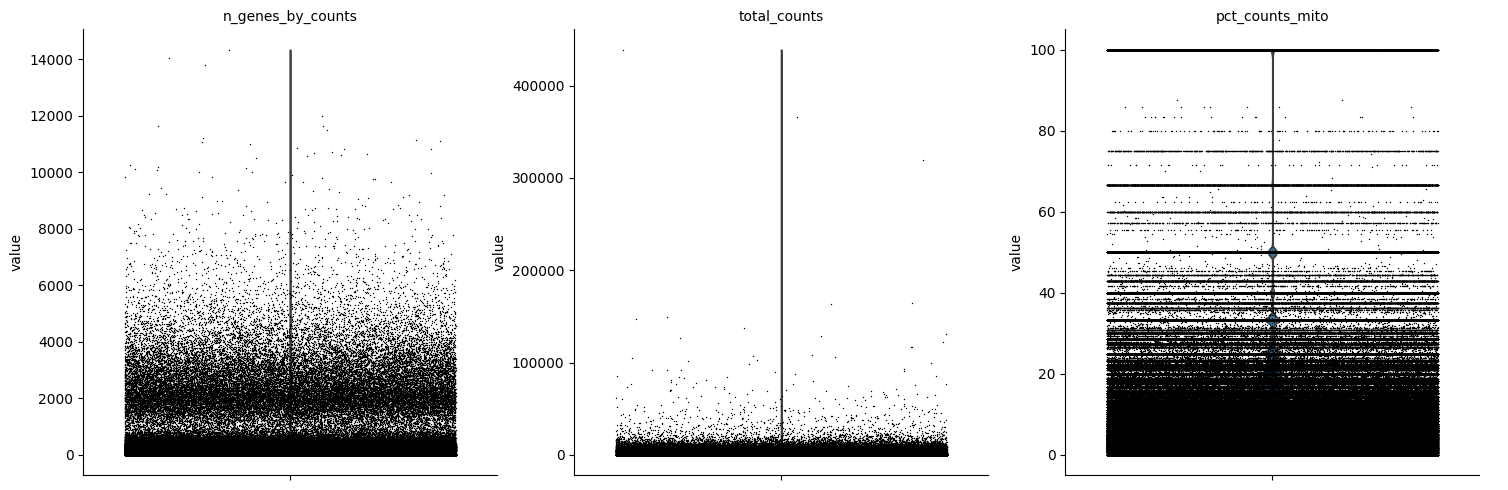

In [47]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'],
             jitter=0.4, multi_panel=True)

In [48]:
#Cell filtering
MIN_GENES = 100
MAX_GENES = 6000

MIN_COUNTS = 100
MAX_COUNTS = 20000

PCT_MITO = 20
PCT_RIBO = 30

#Gene Filtering
PCT_CELLS = 0.25

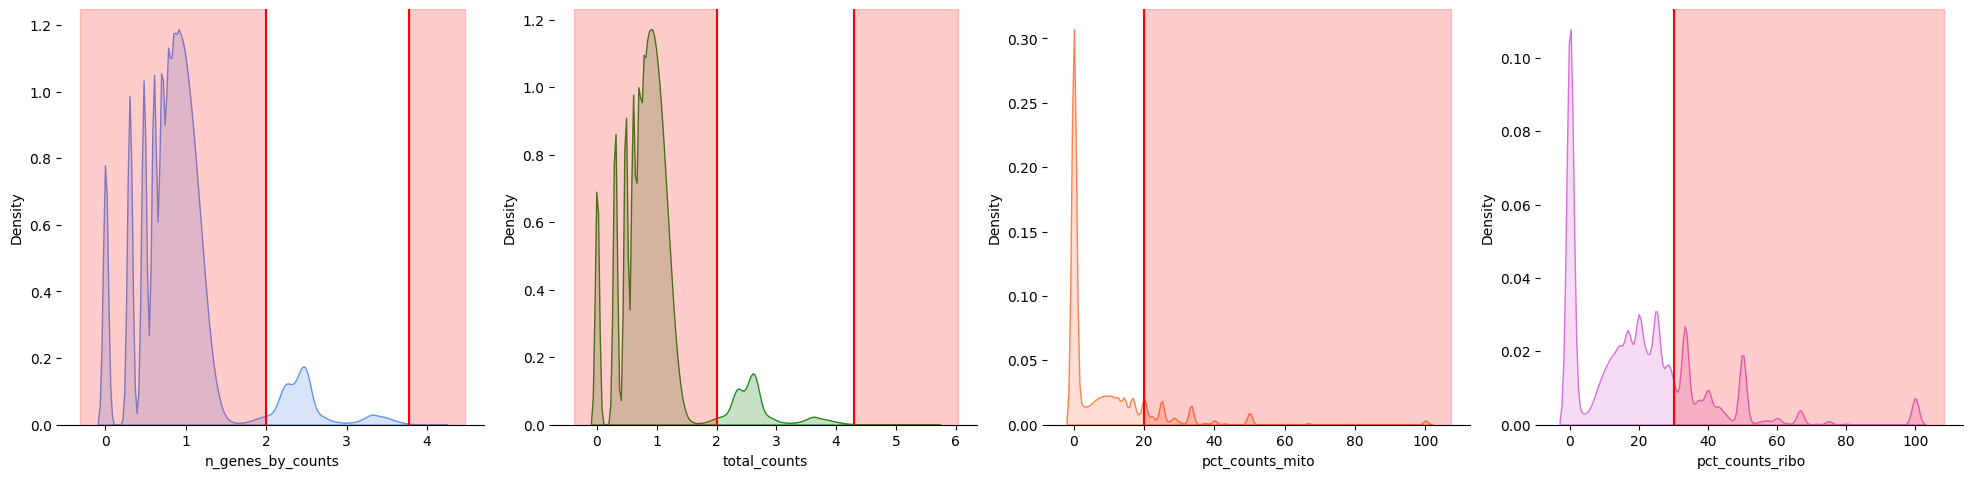

In [49]:
fn.densityQCs(adataObj = adata, hue=None, 
              min_counts = MIN_COUNTS, max_counts = MAX_COUNTS, 
              min_genes = MIN_GENES, max_genes = MAX_GENES, 
              pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

In [50]:
# adata = adata[adata.obs.n_genes_by_counts < 8000, :]
# adata = adata[adata.obs.total_counts < 10000, :]
# adata = adata[adata.obs.pct_counts_mt < 20, :]
# gc.collect()

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


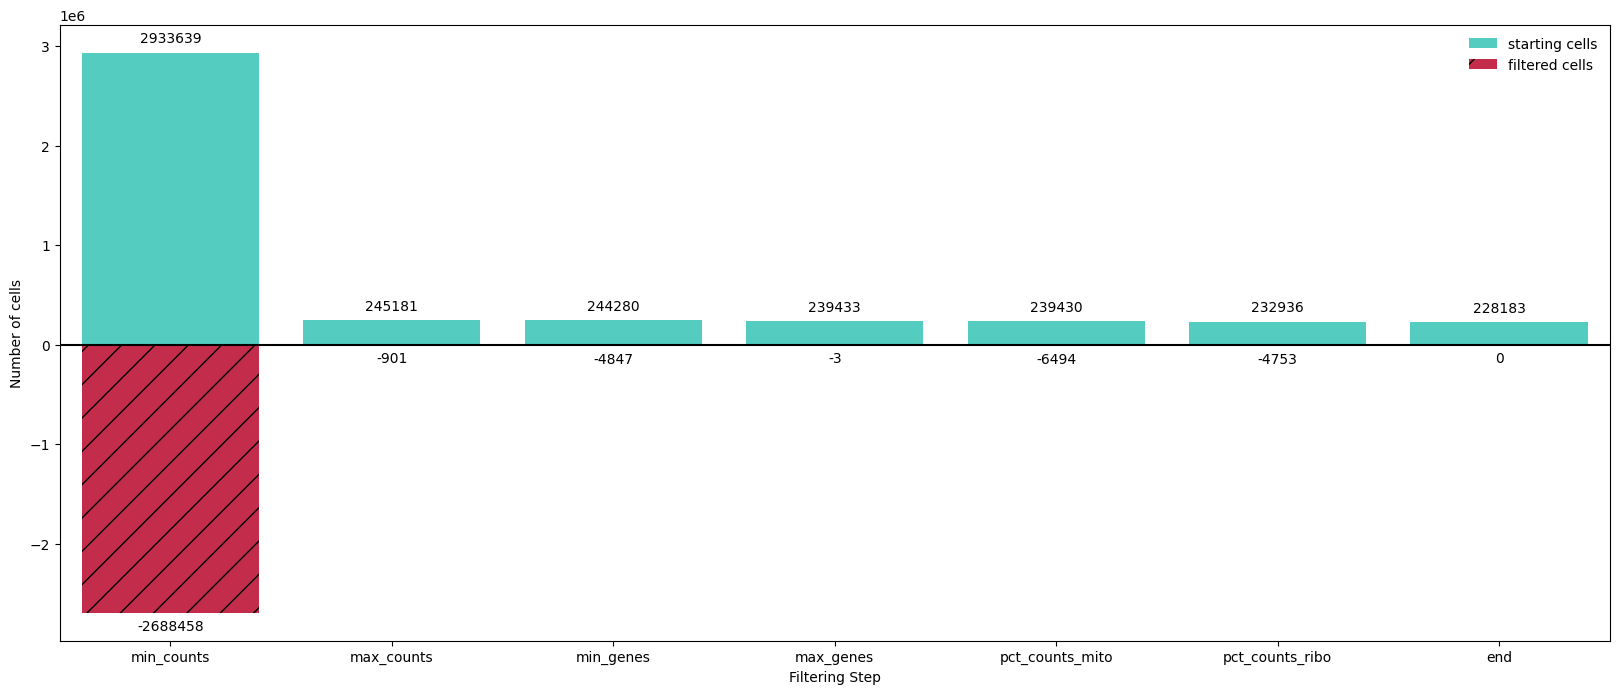

In [51]:
fn.filterCellBarplot(adataObj=adata,
                     min_counts=MIN_COUNTS, max_counts=MAX_COUNTS,
                     min_genes=MIN_GENES, max_genes=MAX_GENES,
                     pct_counts_mito = PCT_MITO, pct_counts_ribo = PCT_RIBO)

In [52]:
print('\nThe selected filtering parameters are:' 
      '\n Minimum counts: ' , MIN_COUNTS, '\n Maximum counts:' , MAX_COUNTS,
      '\n Minimum genes: ' , MIN_GENES, '\n Maximum genes:' , MAX_GENES,
      '\n Mitocondia: ' , PCT_MITO, '%', '\n Ribosomal: ', PCT_RIBO, '%')

sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_cells(adata, max_genes=MAX_GENES)
print('After filtering detected genes: number of cells:', adata.n_obs)

sc.pp.filter_cells(adata, min_counts = MIN_COUNTS)
sc.pp.filter_cells(adata, max_counts = MAX_COUNTS)
print('After filtering on min UMI counts:number of cells:', adata.n_obs)

adata = adata[adata.obs['pct_counts_mito'] < PCT_MITO, :]
print('After filtering on mitochondrial RNA: number of cells:', adata.n_obs)

adata = adata[adata.obs['pct_counts_ribo'] < PCT_RIBO, :]
print('After filtering on ribosomal protein RNA: number of cells:', adata.n_obs)

MIN_CELLS = np.rint((adata.n_obs*PCT_CELLS)/100) 
print('\nGene expressed in less than ', PCT_CELLS, '% cells, corresponding to a number of ', 
     MIN_CELLS, ', are filtered out.')

print('Before gene filtering: number of genes:', adata.n_vars)
sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
print('After gene filtering: number of genes:', adata.n_vars)


The selected filtering parameters are:
 Minimum counts:  100 
 Maximum counts: 20000 
 Minimum genes:  100 
 Maximum genes: 6000 
 Mitocondia:  20 % 
 Ribosomal:  30 %
filtered out 2693305 cells that have less than 100 genes expressed


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 605 cells that have more than 6000 genes expressed
After filtering detected genes: number of cells: 239729
filtered out 299 cells that have more than 20000 counts


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


After filtering on min UMI counts:number of cells: 239430
After filtering on mitochondrial RNA: number of cells: 232936
After filtering on ribosomal protein RNA: number of cells: 228183

Gene expressed in less than  0.25 % cells, corresponding to a number of  570.0 , are filtered out.
Before gene filtering: number of genes: 32286
filtered out 18701 genes that are detected in less than 570.0 cells


/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


After gene filtering: number of genes: 13585


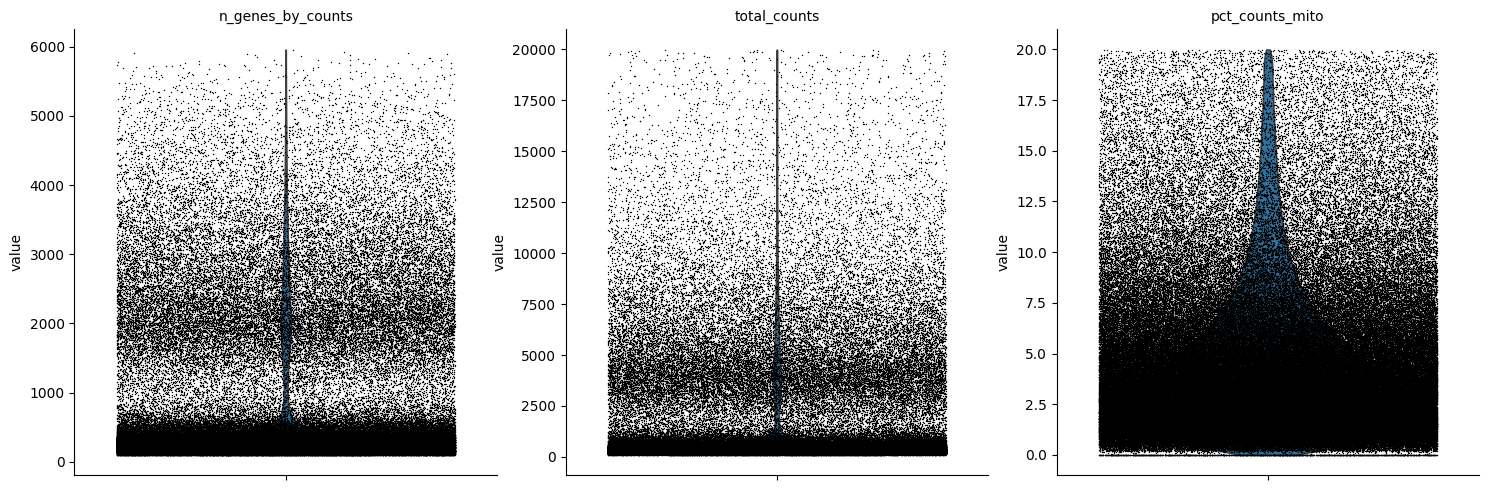

In [53]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'],
             jitter=0.4, multi_panel=True)

In [54]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [55]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [56]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

computing PCA
    with n_comps=50


    finished (0:00:19)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:04:08)


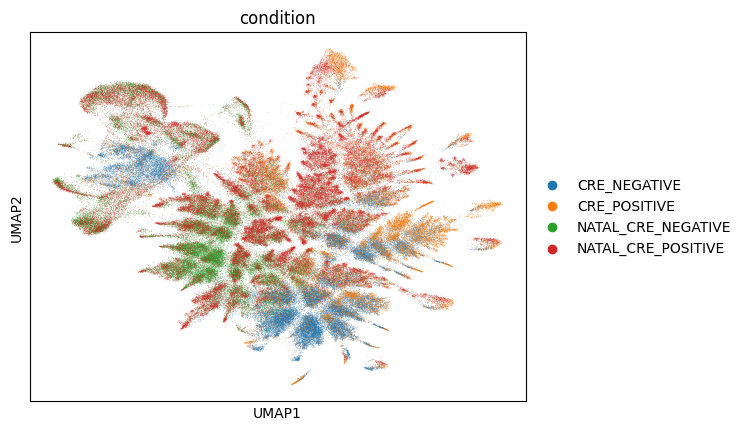

In [57]:
sc.pl.umap(adata, color=['condition'], wspace=0.4)

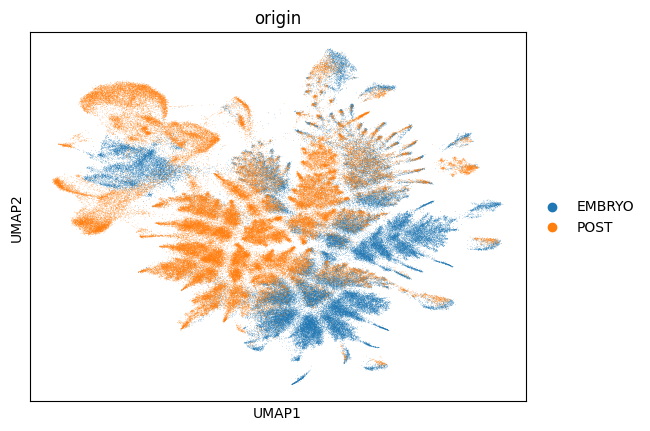

In [58]:
sc.pl.umap(adata, color=['origin'], wspace=0.4)

In [59]:
adata.write('./output/processed_combined_data_from_raw.h5ad')

In [60]:
# # Save as Seurat object
# import anndata2ri
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr

# # Activate automatic conversion between AnnData and SingleCellExperiment
# anndata2ri.activate()

# # Import necessary R packages
# seurat = importr('Seurat')
# base = importr('base')

# # Convert AnnData to SingleCellExperiment
# sce = anndata2ri.py2rpy(adata)

# # Create Seurat object
# seurat_obj = seurat.CreateSeuratObject(counts=sce.slots['assays'].slots['X'],
#                                        meta_data=sce.slots['colData'])

# # Save Seurat object
# base.saveRDS(seurat_obj, "./output/processed_combined_data_from_raw.rds")

# # To load this Seurat object in R using rpy2, you can use the following code:
# # (This part is just for demonstration, it won't actually run in the Python environment)

# '''
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr

# # Import necessary R packages
# base = importr('base')
# seurat = importr('Seurat')

# # Load the Seurat object
# seurat_obj = base.readRDS("./output/processed_combined_data_from_raw.rds")

# # Now you can use the Seurat object in your R environment via rpy2
# '''
